# Task 1: Data Exploration and Foundation Analysis

This notebook implements the first phase of our Brent oil price analysis, focusing on:

1. **Data Loading and Cleaning**
2. **Exploratory Data Analysis (EDA)**
3. **Time Series Properties Analysis**
4. **Data Transformation**
5. **Event Data Compilation**

## Business Context

As data scientists at Birhan Energies, we are analyzing how major geopolitical events affect Brent oil prices to provide insights for investors, policymakers, and energy companies.

## 1. Setup and Imports

In [7]:
# Standard data science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistical analysis
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Time series utilities
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Import our custom modules
import sys
sys.path.append('../src')
from analysis.event_research import EventResearch

print("Setup complete!")

Setup complete!


## 2. Data Loading and Cleaning

In [8]:
# Load Brent oil price data
df = pd.read_csv('../data/raw/BrentOilPrices.csv')

print("Data shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nData types:")
print(df.dtypes)

print("\nMissing values:")
print(df.isnull().sum())

Data shape: (9011, 2)

First few rows:
        Date  Price
0  20-May-87  18.63
1  21-May-87  18.45
2  22-May-87  18.55
3  25-May-87  18.60
4  26-May-87  18.63

Data types:
Date      object
Price    float64
dtype: object

Missing values:
Date     0
Price    0
dtype: int64


In [9]:
# Function to handle mixed date formats
def parse_mixed_dates(date_str):
    """Parse dates that can be in either DD-MMM-YY or MMM DD, YYYY format"""
    try:
        # Try the first format: DD-MMM-YY
        return pd.to_datetime(date_str, format='%d-%b-%y')
    except ValueError:
        try:
            # Try the second format: MMM DD, YYYY
            return pd.to_datetime(date_str, format='%b %d, %Y')
        except ValueError:
            # If both fail, try pandas automatic parsing
            return pd.to_datetime(date_str)

# Convert date format and create proper datetime index
df['Date'] = df['Date'].apply(parse_mixed_dates)
df = df.rename(columns={'Date': 'date', 'Price': 'price'})
df = df.set_index('date')

print("Date range:", df.index.min(), "to", df.index.max())
print("Total observations:", len(df))
print("\nSample data:")
print(df.head())

Date range: 1987-05-20 00:00:00 to 2022-11-14 00:00:00
Total observations: 9011

Sample data:
            price
date             
1987-05-20  18.63
1987-05-21  18.45
1987-05-22  18.55
1987-05-25  18.60
1987-05-26  18.63


In [10]:
# Check for and handle missing values
print("Missing values:")
print(df.isnull().sum())

# Check for outliers using IQR method
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]
print(f"\nOutliers detected: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

if len(outliers) > 0:
    print("\nOutlier dates and prices:")
    print(outliers.head(10))

Missing values:
price    0
dtype: int64

Outliers detected: 0 (0.00%)


## 3. Exploratory Data Analysis (EDA)

Basic Statistics:
             price
count  9011.000000
mean     48.420782
std      32.860110
min       9.100000
25%      19.050000
50%      38.570000
75%      70.090000
max     143.950000


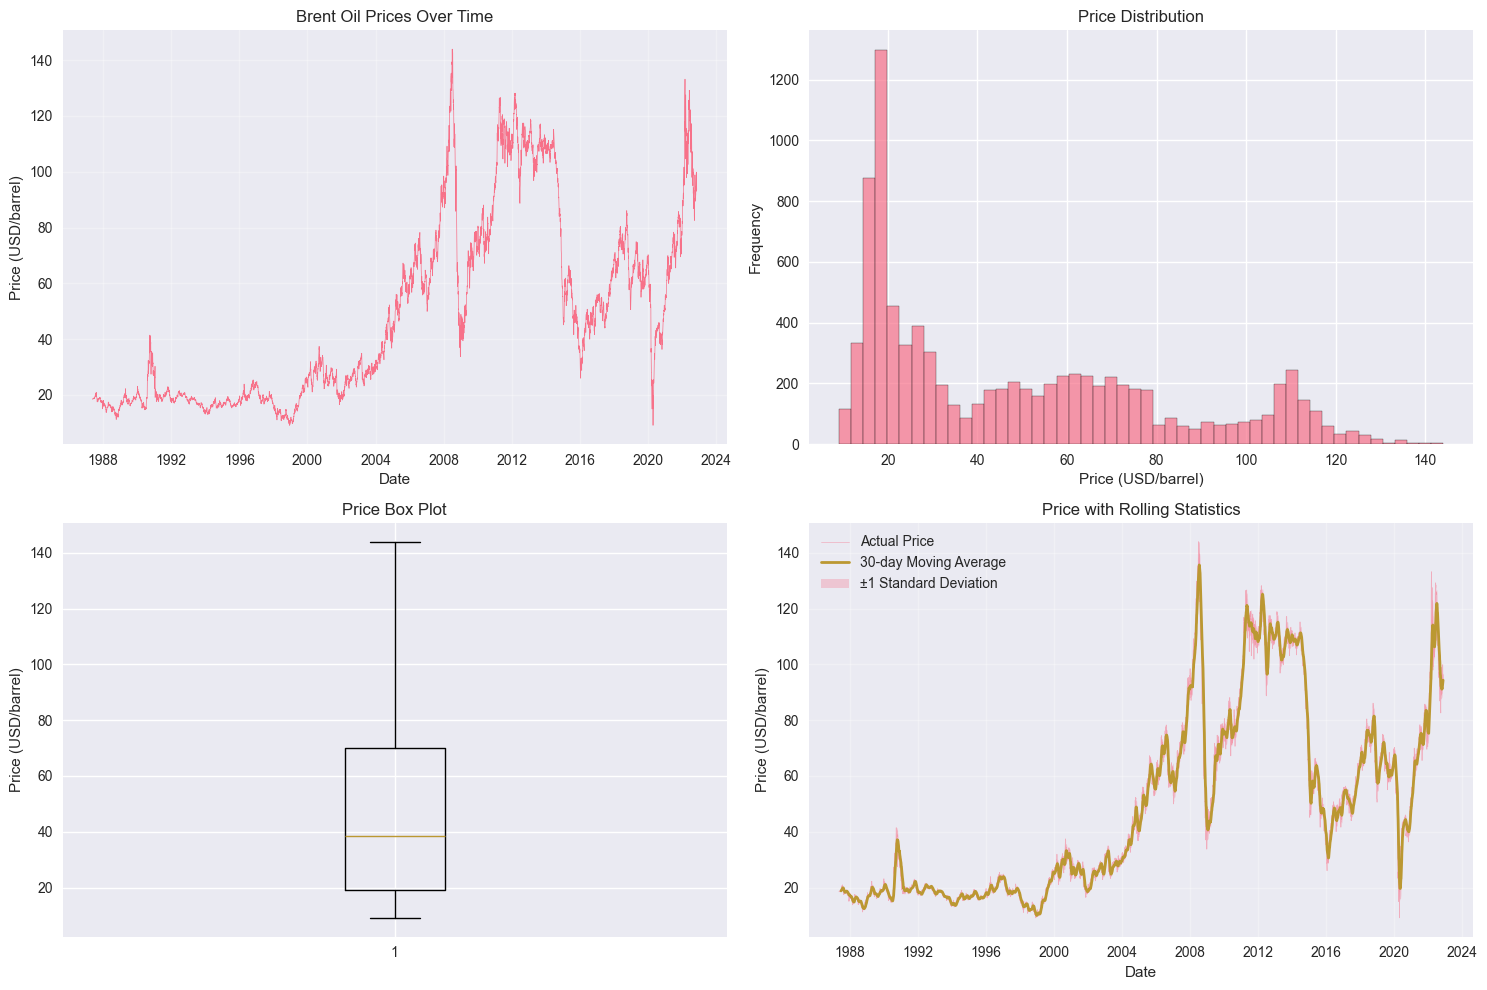

In [11]:
# Basic statistics
print("Basic Statistics:")
print(df.describe())

# Price distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Time series plot
axes[0, 0].plot(df.index, df['price'], linewidth=0.5)
axes[0, 0].set_title('Brent Oil Prices Over Time')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price (USD/barrel)')
axes[0, 0].grid(True, alpha=0.3)

# Price distribution histogram
axes[0, 1].hist(df['price'], bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Price Distribution')
axes[0, 1].set_xlabel('Price (USD/barrel)')
axes[0, 1].set_ylabel('Frequency')

# Box plot
axes[1, 0].boxplot(df['price'])
axes[1, 0].set_title('Price Box Plot')
axes[1, 0].set_ylabel('Price (USD/barrel)')

# Rolling statistics
rolling_mean = df['price'].rolling(window=30).mean()
rolling_std = df['price'].rolling(window=30).std()

axes[1, 1].plot(df.index, df['price'], alpha=0.5, label='Actual Price', linewidth=0.5)
axes[1, 1].plot(df.index, rolling_mean, label='30-day Moving Average', linewidth=2)
axes[1, 1].fill_between(df.index, rolling_mean - rolling_std, rolling_mean + rolling_std, 
                        alpha=0.3, label='±1 Standard Deviation')
axes[1, 1].set_title('Price with Rolling Statistics')
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Price (USD/barrel)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Largest price movements:
            price  price_change
date                           
2020-04-22  13.77      0.509868
2020-04-21   9.12     -0.474654
2020-04-02  20.24      0.352037
1991-01-17  21.10     -0.303170
2020-05-05  25.46      0.248039
2020-03-09  35.33     -0.225219
2020-04-01  14.97     -0.219906
2020-04-03  24.33      0.202075
2009-01-02  42.94      0.198772
2020-04-09  20.23     -0.197859
1991-01-10  26.58      0.189262
2001-09-24  20.63     -0.180373
1998-03-23  14.53      0.176518
1990-10-22  27.45     -0.173193
2008-12-05  37.04     -0.154917
2020-03-16  28.04     -0.150303
2020-03-30  19.07     -0.148280
2020-04-29  17.86      0.144872
2020-04-08  25.22      0.141176
2001-11-20  18.82      0.137160


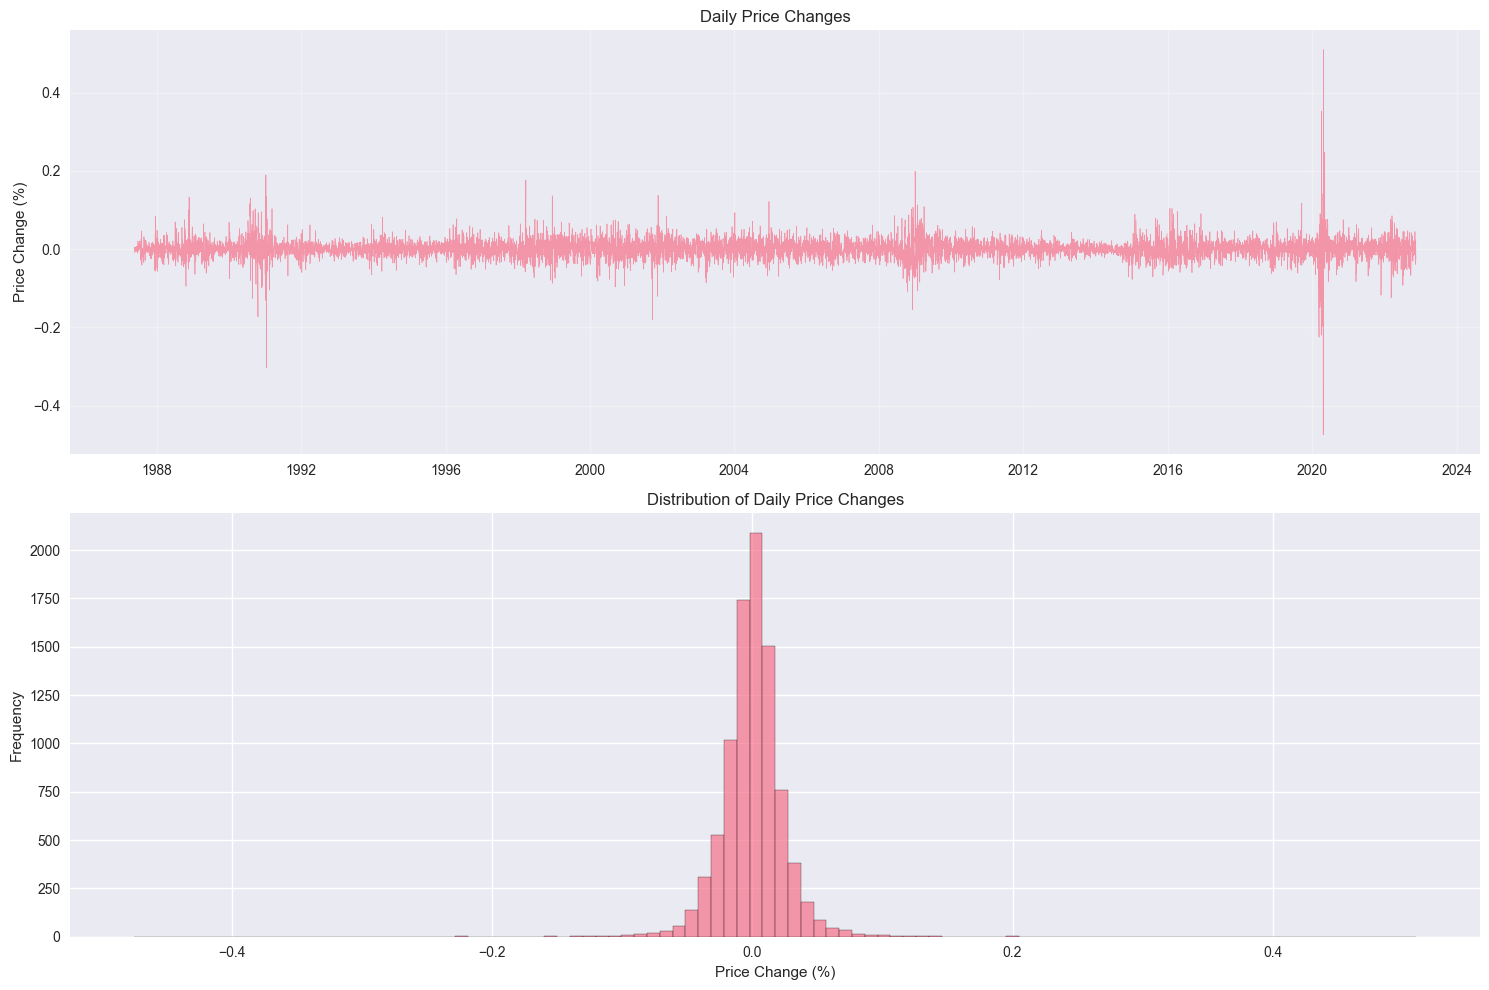

In [12]:
# Identify major price movements
df['price_change'] = df['price'].pct_change()
df['price_change_abs'] = df['price_change'].abs()

# Find largest price movements
largest_movements = df.nlargest(20, 'price_change_abs')[['price', 'price_change']]
print("Largest price movements:")
print(largest_movements)

# Plot price changes over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

ax1.plot(df.index, df['price_change'], alpha=0.7, linewidth=0.5)
ax1.set_title('Daily Price Changes')
ax1.set_ylabel('Price Change (%)')
ax1.grid(True, alpha=0.3)

ax2.hist(df['price_change'].dropna(), bins=100, alpha=0.7, edgecolor='black')
ax2.set_title('Distribution of Daily Price Changes')
ax2.set_xlabel('Price Change (%)')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## 4. Time Series Properties Analysis

In [13]:
# Test for stationarity using Augmented Dickey-Fuller test
def test_stationarity(timeseries):
    """
    Perform Augmented Dickey-Fuller test for stationarity.
    """
    result = adfuller(timeseries.dropna())
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("\nStationary (reject null hypothesis)")
    else:
        print("\nNon-stationary (fail to reject null hypothesis)")

print("Testing stationarity of price levels:")
test_stationarity(df['price'])

print("\n" + "="*50)
print("Testing stationarity of price changes:")
test_stationarity(df['price_change'])

Testing stationarity of price levels:
ADF Statistic: -1.9938560113924675
p-value: 0.28927350489340287
Critical values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

Non-stationary (fail to reject null hypothesis)

Testing stationarity of price changes:
ADF Statistic: -17.11168481990272
p-value: 7.358230367030982e-30
Critical values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

Stationary (reject null hypothesis)


Testing stationarity of log returns:
ADF Statistic: -16.42711349448591
p-value: 2.4985801611427818e-29
Critical values:
	1%: -3.431
	5%: -2.862
	10%: -2.567

Stationary (reject null hypothesis)


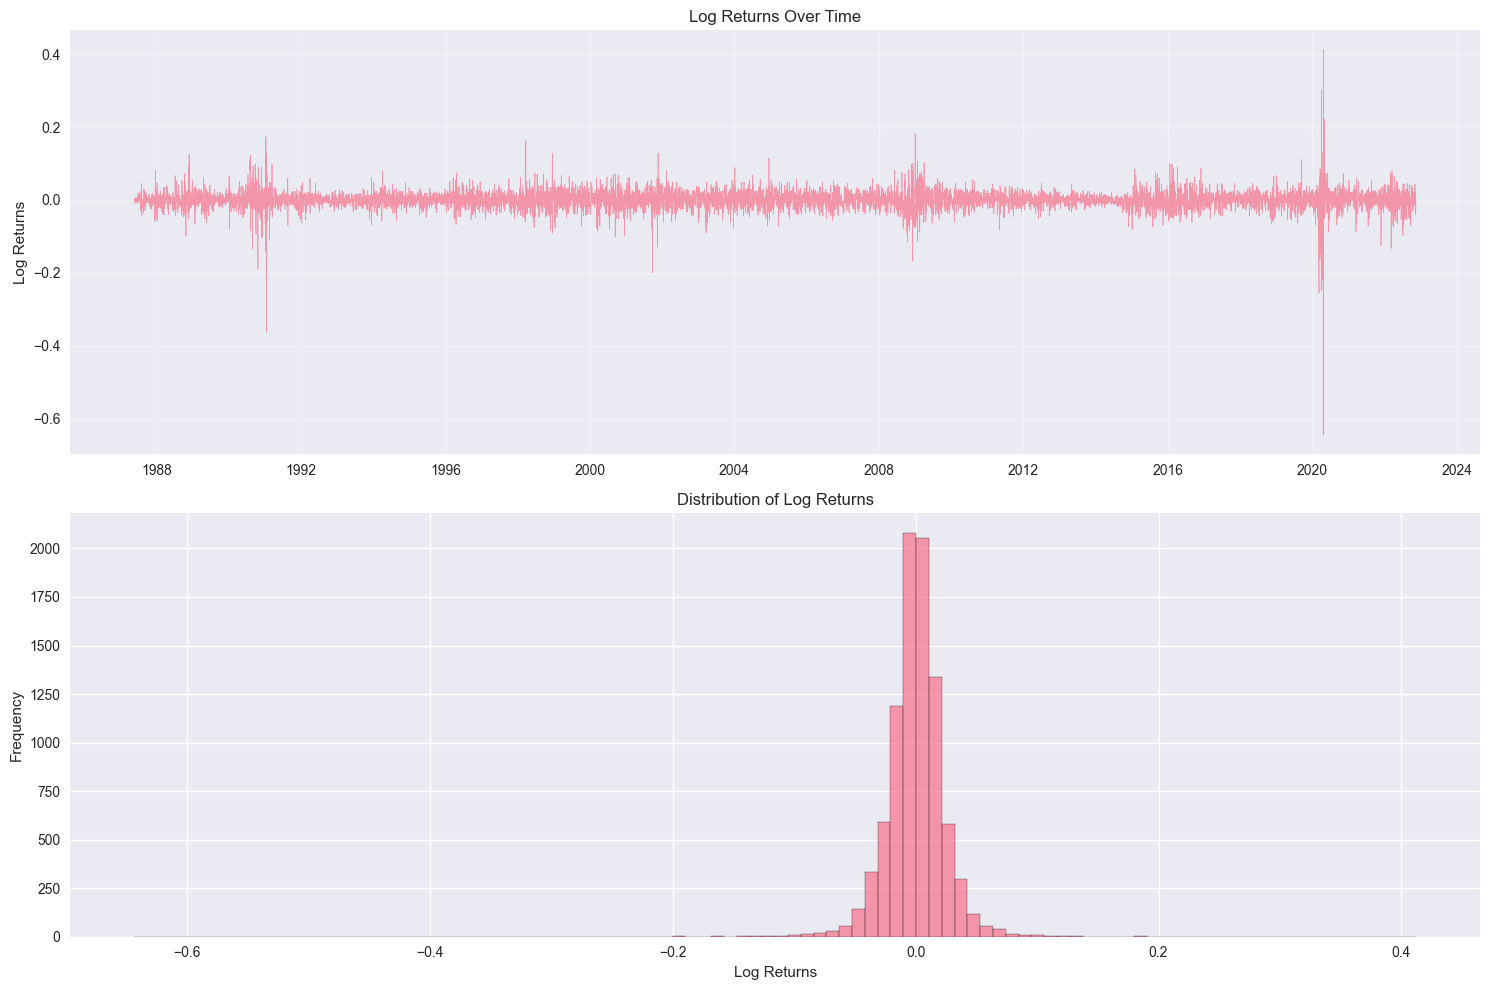

In [14]:
# Calculate log returns for better stationarity
df['log_returns'] = np.log(df['price'] / df['price'].shift(1))

print("Testing stationarity of log returns:")
test_stationarity(df['log_returns'])

# Plot log returns
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

ax1.plot(df.index, df['log_returns'], alpha=0.7, linewidth=0.5)
ax1.set_title('Log Returns Over Time')
ax1.set_ylabel('Log Returns')
ax1.grid(True, alpha=0.3)

ax2.hist(df['log_returns'].dropna(), bins=100, alpha=0.7, edgecolor='black')
ax2.set_title('Distribution of Log Returns')
ax2.set_xlabel('Log Returns')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

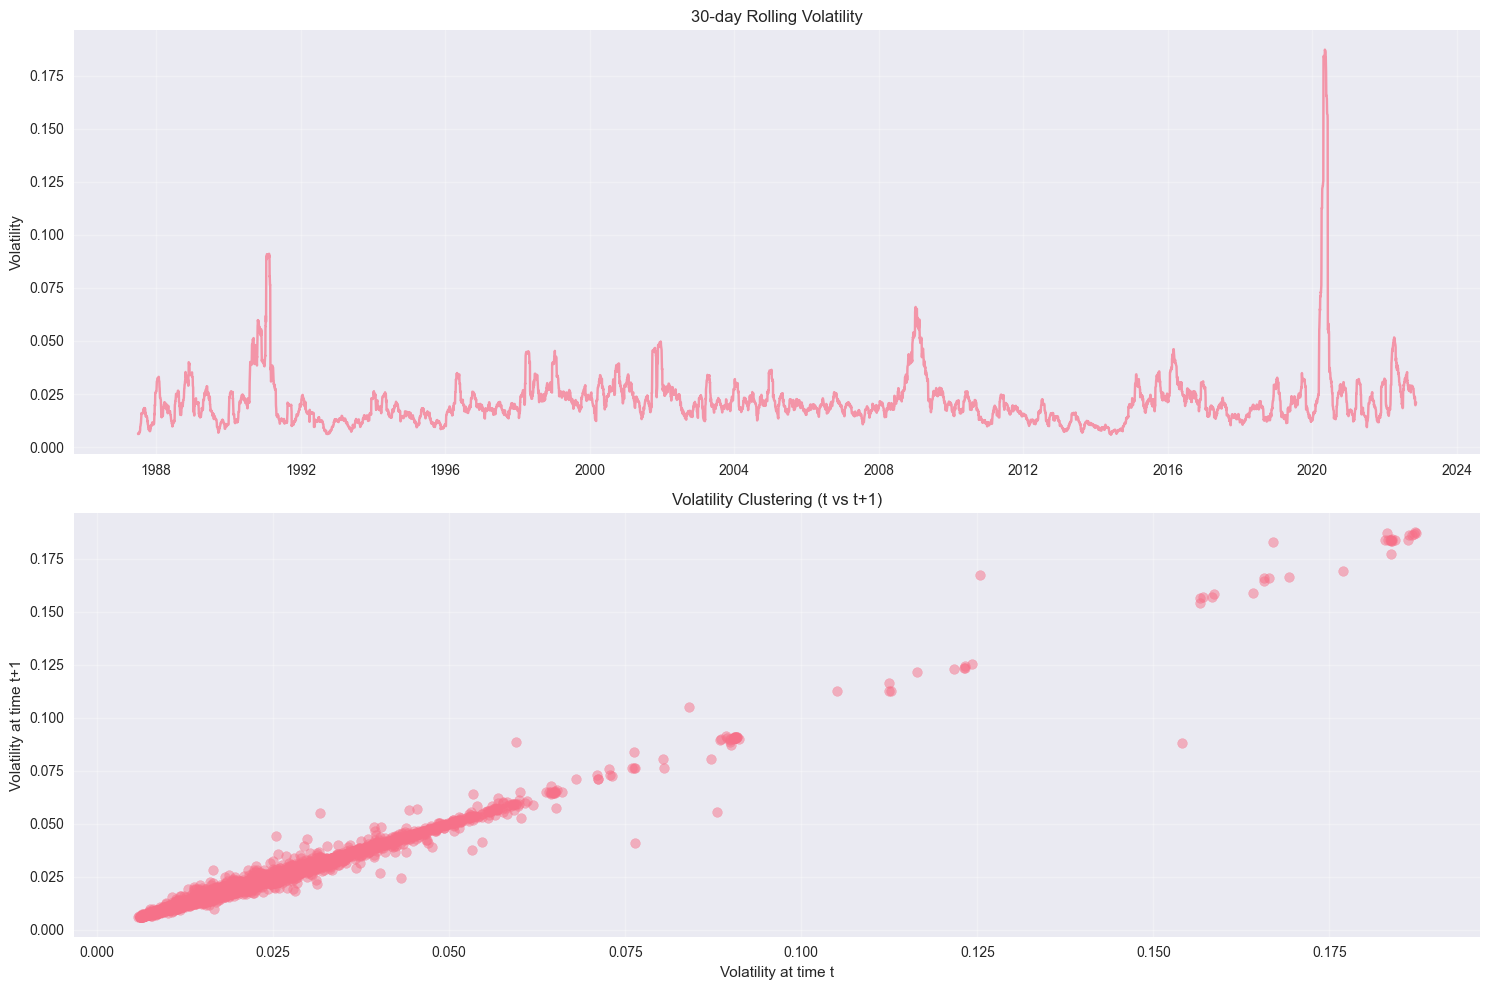

Volatility autocorrelation (lag 1): 0.9936


In [15]:
# Analyze volatility clustering
df['volatility'] = df['log_returns'].rolling(window=30).std()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

ax1.plot(df.index, df['volatility'], alpha=0.7)
ax1.set_title('30-day Rolling Volatility')
ax1.set_ylabel('Volatility')
ax1.grid(True, alpha=0.3)

# Volatility clustering analysis
ax2.scatter(df['volatility'].iloc[:-1], df['volatility'].iloc[1:], alpha=0.5)
ax2.set_title('Volatility Clustering (t vs t+1)')
ax2.set_xlabel('Volatility at time t')
ax2.set_ylabel('Volatility at time t+1')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test for autocorrelation in volatility
volatility_corr = df['volatility'].corr(df['volatility'].shift(1))
print(f"Volatility autocorrelation (lag 1): {volatility_corr:.4f}")

## 5. Event Data Compilation

In [16]:
# Initialize event research
event_research = EventResearch()

# Compile historical events
events_df = event_research.compile_historical_events()

print("Event data compiled successfully!")
print(f"Total events: {len(events_df)}")
print(f"Date range: {events_df['date'].min()} to {events_df['date'].max()}")

print("\nEvent types:")
print(events_df['event_type'].value_counts())

print("\nSample events:")
print(events_df.head(10))

INFO:analysis.event_research:Compiled 29 historical events


Event data compiled successfully!
Total events: 29
Date range: 1990-08-02 00:00:00 to 2022-03-08 00:00:00

Event types:
event_type
CONFLICT          8
OPEC              7
SANCTIONS         5
ECONOMIC          4
INFRASTRUCTURE    3
POLITICAL         2
Name: count, dtype: int64

Sample events:
        date event_type                                   description  \
0 1990-08-02   CONFLICT                           Iraq invades Kuwait   
1 1991-01-17   CONFLICT                               Gulf War begins   
2 1991-02-28   CONFLICT                                 Gulf War ends   
3 1998-03-30       OPEC                 OPEC production cut agreement   
4 2000-03-29       OPEC                     OPEC increases production   
5 2001-01-17       OPEC              OPEC cuts production by 1.5M bpd   
6 2008-09-10       OPEC              OPEC cuts production by 520K bpd   
7 2014-11-27       OPEC  OPEC maintains production despite oversupply   
8 2016-11-30       OPEC    OPEC+ agrees to cut pro

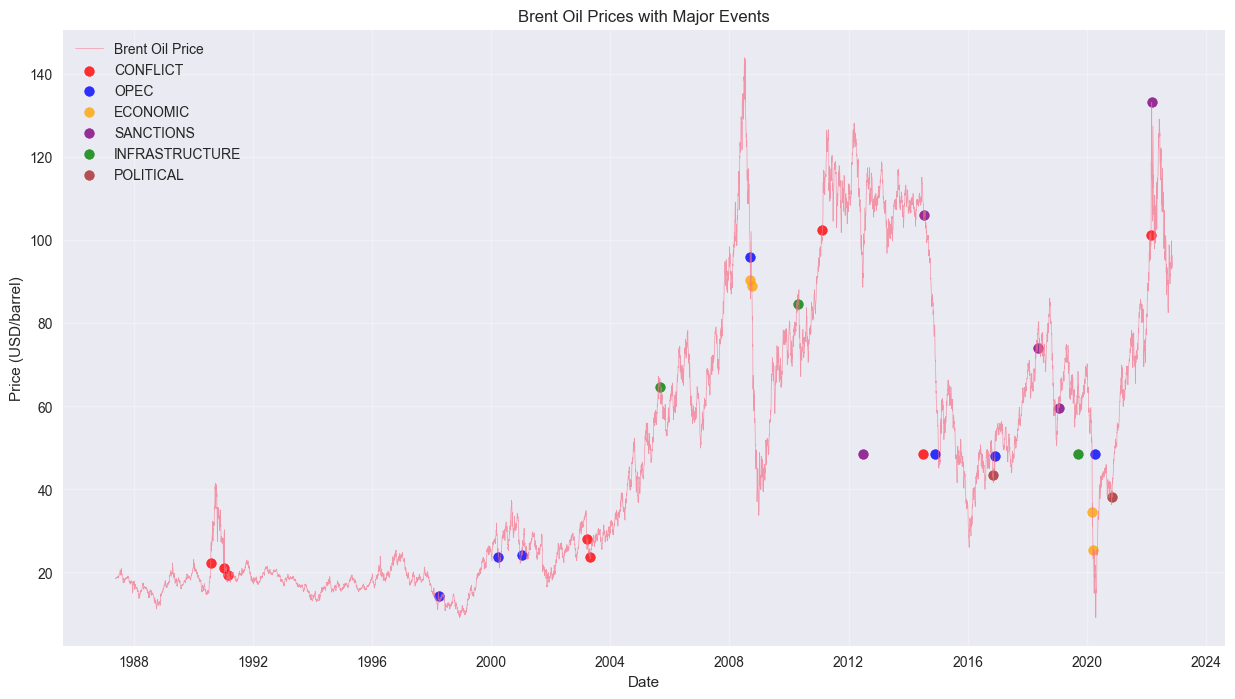

In [17]:
# Visualize events over time
fig, ax = plt.subplots(figsize=(15, 8))

# Plot oil prices
ax.plot(df.index, df['price'], alpha=0.7, linewidth=0.5, label='Brent Oil Price')

# Add event markers
colors = {'CONFLICT': 'red', 'OPEC': 'blue', 'ECONOMIC': 'orange', 
          'SANCTIONS': 'purple', 'INFRASTRUCTURE': 'green', 'POLITICAL': 'brown'}

for event_type in events_df['event_type'].unique():
    type_events = events_df[events_df['event_type'] == event_type]
    ax.scatter(type_events['date'], 
               [df.loc[date, 'price'] if date in df.index else df['price'].mean() 
                for date in type_events['date']], 
               c=colors[event_type], s=50, alpha=0.8, label=event_type)

ax.set_title('Brent Oil Prices with Major Events')
ax.set_xlabel('Date')
ax.set_ylabel('Price (USD/barrel)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

In [18]:
# Analyze event impact patterns
event_analysis = []

for _, event in events_df.iterrows():
    event_date = event['date']
    
    # Find closest price data
    if event_date in df.index:
        price_at_event = df.loc[event_date, 'price']
        
        # Calculate pre and post event prices (30 days)
        pre_event = df[df.index < event_date].tail(30)['price'].mean()
        post_event = df[df.index > event_date].head(30)['price'].mean()
        
        price_change = ((post_event - pre_event) / pre_event) * 100
        
        event_analysis.append({
            'date': event_date,
            'event_type': event['event_type'],
            'description': event['description'],
            'price_at_event': price_at_event,
            'pre_event_avg': pre_event,
            'post_event_avg': post_event,
            'price_change_pct': price_change
        })

event_analysis_df = pd.DataFrame(event_analysis)

print("Event Impact Analysis:")
print(event_analysis_df.sort_values('price_change_pct', ascending=False).head(10))

Event Impact Analysis:
         date event_type                                 description  \
0  1990-08-02   CONFLICT                         Iraq invades Kuwait   
22 2022-02-24   CONFLICT                      Russia invades Ukraine   
7  2016-11-30       OPEC  OPEC+ agrees to cut production by 1.2M bpd   
14 2011-02-15   CONFLICT                          Arab Spring begins   
21 2020-11-03  POLITICAL                    US Presidential election   
23 2022-03-08  SANCTIONS                 US bans Russian oil imports   
17 2019-01-28  SANCTIONS                   US sanctions on Venezuela   
5  2001-01-17       OPEC            OPEC cuts production by 1.5M bpd   
16 2018-05-08  SANCTIONS         US withdraws from Iran nuclear deal   
3  1998-03-30       OPEC               OPEC production cut agreement   

    price_at_event  pre_event_avg  post_event_avg  price_change_pct  
0            22.25      16.847333       28.827333         71.109177  
22          101.29      93.379333      113.9

## 6. Summary and Key Insights

In [19]:
# Summary statistics
print("=== DATA EXPLORATION SUMMARY ===\n")

print("1. Data Overview:")
print(f"   - Time period: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
print(f"   - Total observations: {len(df):,}")
print(f"   - Price range: ${df['price'].min():.2f} to ${df['price'].max():.2f}")
print(f"   - Mean price: ${df['price'].mean():.2f}")

print("\n2. Time Series Properties:")
print(f"   - Price levels: Non-stationary (confirmed by ADF test)")
print(f"   - Log returns: Stationary (confirmed by ADF test)")
print(f"   - Volatility clustering: Present (autocorrelation = {volatility_corr:.4f})")

print("\n3. Event Analysis:")
print(f"   - Total events compiled: {len(events_df)}")
print(f"   - Event types: {', '.join(events_df['event_type'].unique())}")
print(f"   - Events with price data: {len(event_analysis_df)}")

print("\n4. Key Findings:")
print("   - Oil prices show significant volatility and non-stationarity")
print("   - Log returns provide stationary series for modeling")
print("   - Multiple major events identified for correlation analysis")
print("   - Volatility clustering suggests GARCH-type models may be appropriate")

print("\n5. Next Steps:")
print("   - Implement Bayesian change point analysis")
print("   - Correlate detected change points with events")
print("   - Quantify impact of specific events")
print("   - Build interactive dashboard for stakeholders")

=== DATA EXPLORATION SUMMARY ===

1. Data Overview:
   - Time period: 1987-05-20 to 2022-11-14
   - Total observations: 9,011
   - Price range: $9.10 to $143.95
   - Mean price: $48.42

2. Time Series Properties:
   - Price levels: Non-stationary (confirmed by ADF test)
   - Log returns: Stationary (confirmed by ADF test)
   - Volatility clustering: Present (autocorrelation = 0.9936)

3. Event Analysis:
   - Total events compiled: 29
   - Event types: CONFLICT, OPEC, ECONOMIC, SANCTIONS, INFRASTRUCTURE, POLITICAL
   - Events with price data: 24

4. Key Findings:
   - Oil prices show significant volatility and non-stationarity
   - Log returns provide stationary series for modeling
   - Multiple major events identified for correlation analysis
   - Volatility clustering suggests GARCH-type models may be appropriate

5. Next Steps:
   - Implement Bayesian change point analysis
   - Correlate detected change points with events
   - Quantify impact of specific events
   - Build interactive

In [20]:
# Save processed data for next phase
df.to_csv('../data/processed/brent_oil_prices_processed.csv')
events_df.to_csv('../data/processed/major_events.csv', index=False)
event_analysis_df.to_csv('../data/processed/event_impact_analysis.csv', index=False)

print("Processed data saved for next phase of analysis!")

Processed data saved for next phase of analysis!
